# Assignment 3

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model](https://open.spotify.com/track/4R3AU2pjv8ge2siX1fVbZs?si=b2712f32da0e4358) or a simple [linear regression model](https://scikit-learn.org/stable/modules/linear_model.html)
        - An advanced regressor of your choice (e.g., Random Forest, Neural Network, etc.)

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Assuming that the files `adult.data` and `adult.test` are in `../data/adult/`, then you can use the code below to load them.

In [228]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_validate,cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,StandardScaler,QuantileTransformer,PowerTransformer
from sklearn.impute import KNNImputer,SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import  make_scorer, mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")
import pickle
import shap

In [239]:
columns = ['coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' ]
fires_dt = (pd.read_csv('../../05_src/data/fires/forestfires.csv', header = None, names = columns))
fires_dt['area'] = pd.to_numeric(fires_dt['area'], errors='coerce').fillna(0).astype(int)
month_map = {
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
    'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
}
fires_dt['month'] = fires_dt['month'].str.lower().map(month_map).fillna(0).astype(int)
day_map = {
    'mon': 1, 'tue': 2, 'wed': 3, 'thur': 4, 'fri': 5, 'sat': 6, 'sun': 7
}
fires_dt['day'] = fires_dt['day'].str.lower().map(day_map).fillna(0).astype(int)
fires_dt.dtypes
#drop the header row
fires_dt.drop(index=fires_dt.index[0], axis = 0, inplace= True)

In [240]:
# Check for NaN values and handle them
#print(fires_dt.isna().sum())  # Print NaN counts

In [241]:
fires_dt.shape
fires_dt

,coord_x,coord_y,month,day,ffmc,dmc,dc,isi,temp,rh,wind,rain,area
1,7,5,3,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0,0
2,7,4,10,2,90.6,35.4,669.1,6.7,18,33,0.9,0,0
3,7,4,10,6,90.6,43.7,686.9,6.7,14.6,33,1.3,0,0
4,8,6,3,5,91.7,33.3,77.5,9,8.3,97,4,0.2,0
5,8,6,3,7,89.3,51.3,102.2,9.6,11.4,99,1.8,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,4,3,8,7,81.6,56.7,665.6,1.9,27.8,32,2.7,0,6
514,2,4,8,7,81.6,56.7,665.6,1.9,21.9,71,5.8,0,54
515,7,4,8,7,81.6,56.7,665.6,1.9,21.2,70,6.7,0,11
516,1,4,8,6,94.4,146,614.7,11.3,25.6,42,4,0,0


In [242]:
fires_dt.describe()

,month,day,area
count,517.000000,517.000000,517.000000
mean,7.475822,3.787234,12.599613
std,2.275990,2.492079,63.595867
min,1.000000,0.000000,0.000000
25%,7.000000,1.000000,0.000000
50%,8.000000,5.000000,0.000000
75%,9.000000,6.000000,6.000000
max,12.000000,7.000000,1090.000000


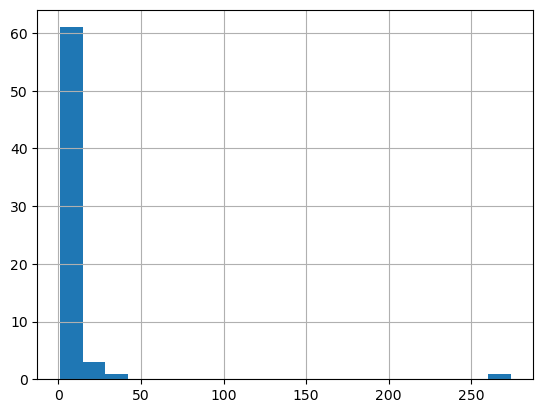

In [243]:
fires_dt['area'].value_counts().hist(bins = 20)
plt.show()

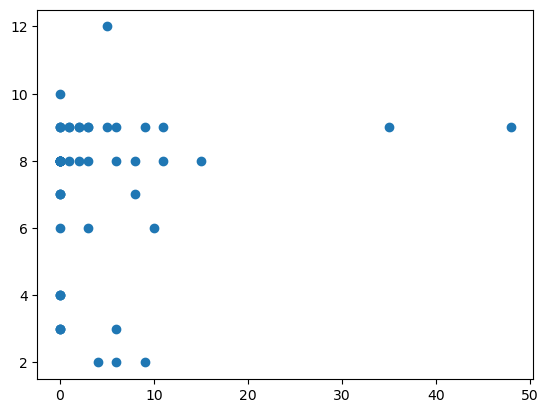

In [244]:
df = fires_dt.sample(frac=.1)
plt.scatter(df['area'], df['month'])
plt.show()

# Get X and Y

Create the features data frame and target data.

In [245]:
X = fires_dt.drop(columns = 'area')
Y = fires_dt['area']
X_train,X_test,Y_train,Y_test= train_test_split(X,Y,test_size =.3, random_state=42)
X,Y

(    coord_x coord_y  month  day  ffmc   dmc     dc   isi  temp  rh wind rain
 1         7       5      3    5  86.2  26.2   94.3   5.1   8.2  51  6.7    0
 2         7       4     10    2  90.6  35.4  669.1   6.7    18  33  0.9    0
 3         7       4     10    6  90.6  43.7  686.9   6.7  14.6  33  1.3    0
 4         8       6      3    5  91.7  33.3   77.5     9   8.3  97    4  0.2
 5         8       6      3    7  89.3  51.3  102.2   9.6  11.4  99  1.8    0
 ..      ...     ...    ...  ...   ...   ...    ...   ...   ...  ..  ...  ...
 513       4       3      8    7  81.6  56.7  665.6   1.9  27.8  32  2.7    0
 514       2       4      8    7  81.6  56.7  665.6   1.9  21.9  71  5.8    0
 515       7       4      8    7  81.6  56.7  665.6   1.9  21.2  70  6.7    0
 516       1       4      8    6  94.4   146  614.7  11.3  25.6  42    4    0
 517       6       3     11    2  79.5     3  106.7   1.1  11.8  31  4.5    0
 
 [517 rows x 12 columns],
 1       0
 2       0
 3       0
 4 

# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [246]:
num_cols = ['coord_x', 'coord_y','ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']
cat_cols = ['month', 'day']

In [247]:
# preproc1
preproc1 = ColumnTransformer(
    transformers=[
        ('numeric_transforms', StandardScaler(), num_cols ),
        ('cat_transforms',OneHotEncoder(handle_unknown='ignore'), cat_cols)
 #       ('cat_transforms', OneHotEncoder(handle_unknown='infrequent_if_exist'), cat_cols)
    ], remainder='drop'
)
preproc1

ColumnTransformer(transformers=[('numeric_transforms', StandardScaler(),
                                 ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                  'isi', 'temp', 'rh', 'wind', 'rain']),
                                ('cat_transforms',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['month', 'day'])])

### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [248]:
#non-linear transformer
pipe_num = Pipeline([
      ('numeric_transforms', StandardScaler()),
      ('power_transform', PowerTransformer(method='yeo-johnson'))
#      ('non-linear transform', QuantileTransformer())
      ])

pipe_cat = Pipeline(
    [
     ('standardizer', OneHotEncoder(handle_unknown='infrequent_if_exist',drop='if_binary'))   ])

In [249]:
#preproc2
preproc2 = ColumnTransformer(
    transformers = [
        ('num_transforms',pipe_num,num_cols),
        ('cat_transforms',pipe_cat, cat_cols)
    ], remainder='drop'
)
preproc2


ColumnTransformer(transformers=[('num_transforms',
                                 Pipeline(steps=[('numeric_transforms',
                                                  StandardScaler()),
                                                 ('power_transform',
                                                  PowerTransformer())]),
                                 ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                  'isi', 'temp', 'rh', 'wind', 'rain']),
                                ('cat_transforms',
                                 Pipeline(steps=[('standardizer',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='infrequent_if_exist'))]),
                                 ['month', 'day'])])

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [250]:
# Pipeline A = preproc1 + baseline
pipeA = Pipeline(
    [
        ('preproc1',preproc1),
    #    ('knn',KNeighborsRegressor())
        ('regressor', LogisticRegression())
    #    ('regressor', LinearRegression())
    ])
pipeA

Pipeline(steps=[('preproc1',
                 ColumnTransformer(transformers=[('numeric_transforms',
                                                  StandardScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('cat_transforms',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('regressor', LogisticRegression())])

In [251]:
# Pipeline B = preproc2 + baseline
pipeB = Pipeline(
    [
        ('preproc2',preproc2),
    #    ('knn',KNeighborsRegressor())
        ('regressor', LogisticRegression())
    #    ('regressor', LinearRegression())
    ])
pipeB

Pipeline(steps=[('preproc2',
                 ColumnTransformer(transformers=[('num_transforms',
                                                  Pipeline(steps=[('numeric_transforms',
                                                                   StandardScaler()),
                                                                  ('power_transform',
                                                                   PowerTransformer())]),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('cat_transforms',
                                                  Pipeline(steps=[('standardizer',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='infrequent_if_exist'))]),
                                                  ['month', 'day'])])),
                ('regressor', LogisticRegression())])

In [252]:
# Pipeline C = preproc1 + advanced model
pipeC = Pipeline(
    [
        ('preproc1',preproc1),
        ('clf', RandomForestClassifier())
    ])
pipeC

Pipeline(steps=[('preproc1',
                 ColumnTransformer(transformers=[('numeric_transforms',
                                                  StandardScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('cat_transforms',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('clf', RandomForestClassifier())])

In [253]:
# Pipeline D = preproc2 + advanced model
pipeD = Pipeline(
    [
        ('preproc2',preproc2),
        ('clf', RandomForestClassifier())
    ])
pipeD

Pipeline(steps=[('preproc2',
                 ColumnTransformer(transformers=[('num_transforms',
                                                  Pipeline(steps=[('numeric_transforms',
                                                                   StandardScaler()),
                                                                  ('power_transform',
                                                                   PowerTransformer())]),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('cat_transforms',
                                                  Pipeline(steps=[('standardizer',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='infrequent_if_exist'))]),
                                                  ['month', 'day'])])),
                ('clf', RandomForestClassifier())])

In [254]:
# scoring = {
#     'rmse': rmse_scorer,
#     'mae': mae_scorer
# }
# # Perform cross-validation for RMSE and MAE
# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# rmse_scoresA = cross_validate(pipeA, X_train, Y_train, cv=kf, scoring=scoring)
# rmse_scoresB = cross_validate(pipeB, X_train, Y_train, cv=kf, scoring=scoring)
# rmse_scoresC = cross_validate(pipeC, X_train, Y_train, cv=kf, scoring=scoring)
# rmse_scoresD = cross_validate(pipeD, X_train, Y_train, cv=kf, scoring=scoring)
# print(f"scores: {rmse_scoresA, rmse_scoresB, rmse_scoresC, rmse_scoresD}")

scores: ({'fit_time': array([0.05254507, 0.04211235, 0.03714442, 0.04700351, 0.03407454]), 'score_time': array([0.00899696, 0.00399971, 0.00699329, 0.00600123, 0.00400019]), 'test_rmse': array([ 28.6129102 ,  29.96039052, 102.37661951,  24.66920032,
         9.58442023]), 'test_mae': array([ 9.16438356, 10.79166667, 28.        ,  8.40277778,  4.66666667])}, {'fit_time': array([0.05138588, 0.05038619, 0.05591726, 0.05464053, 0.06024885]), 'score_time': array([0.00700331, 0.00500083, 0.00600743, 0.00800633, 0.0079987 ]), 'test_rmse': array([ 28.61506453,  29.93349109, 100.02458031,  25.354432  ,
         9.47364766]), 'test_mae': array([ 9.20547945, 10.81944444, 25.41666667,  8.90277778,  4.66666667])}, {'fit_time': array([0.2210207 , 0.21470237, 0.17542338, 0.22215104, 0.19653606]), 'score_time': array([0.01497698, 0.0095551 , 0.01128745, 0.01299596, 0.0079    ]), 'test_rmse': array([ 28.83205978,  30.02822746, 100.15626679,  25.27927346,
        20.02255672]), 'test_mae': array([ 9.753

In [255]:
rmse_scorer = make_scorer(mean_squared_error, squared=False)
mae_scorer = make_scorer(mean_absolute_error)
# Perform cross-validation for RMSE
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scoresA = cross_val_score(pipeA, X_train, Y_train, cv=kf, scoring=rmse_scorer)
rmse_scoresB = cross_val_score(pipeB, X_train, Y_train, cv=kf, scoring=rmse_scorer)
rmse_scoresC = cross_val_score(pipeC, X_train, Y_train, cv=kf, scoring=rmse_scorer)
rmse_scoresD = cross_val_score(pipeD, X_train, Y_train, cv=kf, scoring=rmse_scorer)
print(f"RMSE scores: {rmse_scoresA,rmse_scoresB, rmse_scoresC, rmse_scoresD}")
print(f"Mean RMSE: {np.mean(rmse_scoresA),np.mean(rmse_scoresB),np.mean(rmse_scoresC),np.mean(rmse_scoresD)}")

# Perform cross-validation for MAE
mae_scoresA = cross_val_score(pipeA, X_train, Y_train, cv=kf, scoring=mae_scorer)
mae_scoresB = cross_val_score(pipeB, X_train, Y_train, cv=kf, scoring=mae_scorer)
mae_scoresC = cross_val_score(pipeC, X_train, Y_train, cv=kf, scoring=mae_scorer)
mae_scoresD = cross_val_score(pipeD, X_train, Y_train, cv=kf, scoring=mae_scorer)

print(f"MAE scores: {mae_scoresA, mae_scoresB, mae_scoresC, mae_scoresD}")
print(f"Mean MAE: {np.mean(mae_scoresA), np.mean(mae_scoresB), np.mean(mae_scoresC), np.mean(mae_scoresD)}")

RMSE scores: (array([ 28.6129102 ,  29.96039052, 102.37661951,  24.66920032,
         9.58442023]), array([ 28.61506453,  29.93349109, 100.02458031,  25.354432  ,
         9.47364766]), array([ 28.65548789,  30.20899425, 100.15231456,  25.16363116,
        19.40074454]), array([ 28.64712087,  30.20899425, 100.15321596,  25.23720798,
        19.51246041]))
Mean RMSE: (39.04070815535081, 38.68024311864643, 40.71623448046429, 40.751799892477294)
MAE scores: (array([ 9.16438356, 10.79166667, 28.        ,  8.40277778,  4.66666667]), array([ 9.20547945, 10.81944444, 25.41666667,  8.90277778,  4.66666667]), array([ 9.38356164, 11.16666667, 26.22222222,  9.04166667,  8.13888889]), array([ 9.42465753, 11.625     , 26.27777778,  9.47222222,  6.38888889]))
Mean MAE: (12.205098934550989, 11.802207001522069, 12.790601217656013, 12.637709284627093)


# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [256]:
rmse_scorer = make_scorer(mean_squared_error, squared=False)
mae_scorer = make_scorer(mean_absolute_error)
scoring = 'neg_mean_squared_error'
param_grid_logistic = {
    'regressor__C': [0.01, 0.5, 1.0],
    'regressor__penalty': ['l1', 'l2'],
    'regressor__solver': ['liblinear']
}
param_grid_knn = {
    'knn__n_neighbors': [3, 5, 7, 9, 11, 13, 15],  # Number of neighbors
    'knn__weights': ['uniform' ,'distance'],       # Weight function used in prediction
    'knn__metric': ['manhattan']  # Distance metric
}
param_grid_lr = {
    'regressor__fit_intercept': [True,False] # Whether to calculate the intercept for this model
}

In [257]:
grid_cv_A = GridSearchCV(
    estimator=pipeA, 
    param_grid=param_grid_logistic, 
    scoring = scoring, 
    cv = 5,
    refit = True)
grid_cv_A.fit(X_train, Y_train)
print("Best parameters:", grid_cv_A.best_params_)
print("Best MSE score:", -grid_cv_A.best_score_) 

Best parameters: {'regressor__C': 1.0, 'regressor__penalty': 'l2', 'regressor__solver': 'liblinear'}
Best MSE score: 2464.4477549467274


In [258]:
grid_cv_B = GridSearchCV(
    estimator=pipeB, 
    param_grid=param_grid_logistic, 
    scoring = scoring, 
    cv = 5,
    refit = True)
grid_cv_B.fit(X_train, Y_train)
print("Best parameters:", grid_cv_B.best_params_)
print("Best MSE score:", -grid_cv_B.best_score_) 

Best parameters: {'regressor__C': 1.0, 'regressor__penalty': 'l2', 'regressor__solver': 'liblinear'}
Best MSE score: 2464.450532724505


In [259]:
param_grid2 = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__bootstrap': [True, False]
}
scoring = 'neg_mean_squared_error' 

In [260]:
grid_cv_C = GridSearchCV(
    estimator=pipeC, 
    param_grid=param_grid2, 
    scoring = scoring, 
    cv = 5,
    refit = True)
grid_cv_C.fit(X_train, Y_train)
print("Best parameters:", grid_cv_C.best_params_)
print("Best MSE score:", -grid_cv_C.best_score_) 

Best parameters: {'clf__bootstrap': True, 'clf__max_depth': 20, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 100}
Best MSE score: 2464.0643455098934


In [261]:
grid_cv_D = GridSearchCV(
    estimator=pipeD, 
    param_grid=param_grid2, 
    scoring = scoring, 
    cv = 5,
    refit = True)
grid_cv_D.fit(X_train, Y_train)
print("Best parameters:", grid_cv_D.best_params_)
print("Best MSE score:", -grid_cv_D.best_score_) 

Best parameters: {'clf__bootstrap': False, 'clf__max_depth': None, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 10, 'clf__n_estimators': 100}
Best MSE score: 2464.610882800609


# Evaluate

+ Which model has the best performance?

Model with PipeC (Preproc1 -  Standard Scaler , OneHotEncoder + RandomForestClassifier) has the lowest RMSE (observed as low as 2464.06) indicating better performance than the remaining models

# Export

+ Save the best performing model to a pickle file.

In [262]:
with open('best_model.pkl','wb') as file:
    pickle.dump(grid_cv_C.best_estimator_, file)

# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

In [263]:
X_train.describe(),X_test.describe()

(            month         day
 count  361.000000  361.000000
 mean     7.451524    3.814404
 std      2.276328    2.491410
 min      1.000000    0.000000
 25%      7.000000    1.000000
 50%      8.000000    5.000000
 75%      9.000000    6.000000
 max     12.000000    7.000000,
             month         day
 count  156.000000  156.000000
 mean     7.532051    3.724359
 std      2.281538    2.500513
 min      1.000000    0.000000
 25%      8.000000    1.000000
 50%      8.000000    4.000000
 75%      9.000000    6.000000
 max     12.000000    7.000000)

In [264]:
X_test, X_test

(    coord_x coord_y  month  day  ffmc    dmc     dc   isi  temp  rh wind rain
 305       6       5      5    6  85.1     28  113.8   3.5  11.3  94  4.9    0
 502       7       5      8    2  96.1  181.1  671.2  14.3  21.6  65  4.9  0.8
 442       8       6      8    1  92.1    207  672.6   8.2  25.5  29  1.8    0
 154       5       4      9    5  94.3   85.1  692.3  15.9  20.1  47  4.9    0
 504       2       4      8    3  94.5  139.4  689.1    20  29.2  30  4.9    0
 ..      ...     ...    ...  ...   ...    ...    ...   ...   ...  ..  ...  ...
 193       2       2      8    2  94.8  108.3  647.1    17  24.6  22  4.5    0
 67        2       2      9    5  92.4  117.9    668  12.2    23  37  4.5    0
 287       7       6      7    3  91.2  183.1  437.7  12.5  12.6  90  7.6  0.2
 423       8       6      7    7  88.9  263.1  795.9   5.2  29.3  27  3.6    0
 95        8       6      8    1  91.1  103.2  638.8   5.8  23.4  22  2.7    0
 
 [156 rows x 12 columns],
     coord_x coord_y  mo

In [265]:
pipeC.fit(X_test,Y_test)

Pipeline(steps=[('preproc1',
                 ColumnTransformer(transformers=[('numeric_transforms',
                                                  StandardScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('cat_transforms',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('clf', RandomForestClassifier())])

In [266]:
grid_cv_C.fit(X_test, Y_test)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preproc1',
                                        ColumnTransformer(transformers=[('numeric_transforms',
                                                                         StandardScaler(),
                                                                         ['coord_x',
                                                                          'coord_y',
                                                                          'ffmc',
                                                                          'dmc',
                                                                          'dc',
                                                                          'isi',
                                                                          'temp',
                                                                          'rh',
                                                                          'wind',
                                                                          'rain']),
                                                                        ('cat_transforms',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['month',
                                                                          'day'])])),
                                       ('clf', RandomForestClassifier())]),
             param_grid={'clf__bootstrap': [True, False],
                         'clf__max_depth': [None, 10, 20],
                         'clf__min_samples_leaf': [1, 2, 4],
                         'clf__min_samples_split': [2, 5, 10],
                         'clf__n_estimators': [100, 200]},
             scoring='neg_mean_squared_error')

In [267]:
data_transform = pipeC.named_steps['preproc1'].transform(X_test)

explainer = shap.TreeExplainer(
    pipeC.named_steps['clf'])

shap_values = explainer.shap_values(data_transform)

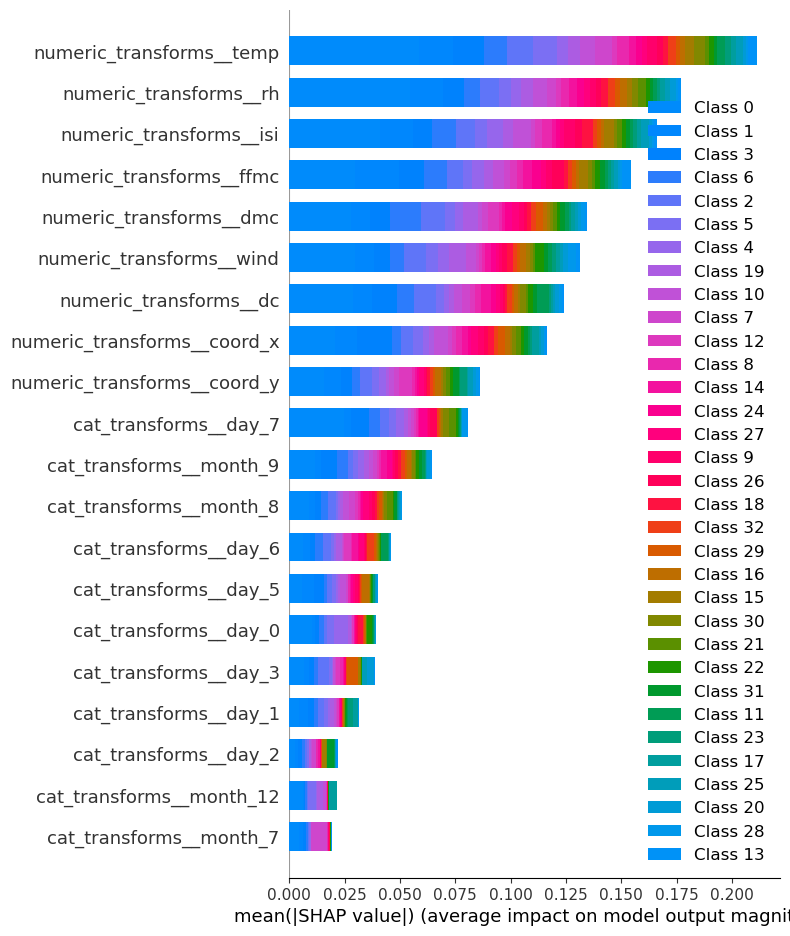

In [268]:
shap.summary_plot(shap_values, data_transform, feature_names=pipeC.named_steps['preproc1'].get_feature_names_out())

*(Answer here.)*
+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.
    --> By plotting the SHAP values for the observation, we can see which features contributed positively or negatively to the prediction and by how much. The most important features will be those with the highest absolute SHAP values for that particular observation.
    - In general, across the complete training set, which features are the most and least important.
    --> The temp, rh(relative humidity), isi(initial spread index) are the most important features.
    The day value seems to have the least impact on the model. Also, some months have least importance for instance July and December.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?
-->I would remove the day feature because it has little impact on the model suggested by its lower position on the plot. ALso, we can only consider data for months which have higher importance.Reducing the number of less relevant features could simplify the model and improve performance by reducing noise.
To test this, we can remove these features and conditional month data from the dataset before splitting the data and use the new dataframe for modelling. Compare the performance of the model with and without the excluded features to determine if their removal enhances model performance.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-3`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_3.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.